Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.5.2
IPython 7.3.0

torch 1.0.1.post2


- Runs on CPU or GPU (if available)

# Model Zoo -- Convolutional Conditional Variational Autoencoder 

## (with labels in reconstruction loss)

A simple convolutional conditional variational autoencoder that compresses 768-pixel MNIST images down to a 50-pixel latent vector representation.

This implementation concatenates the inputs with the class labels when computing the reconstruction loss as it is commonly done in non-convolutional conditional variational autoencoders. This leads to substantially poorer results compared to the implementation that does NOT concatenate the labels with the inputs to compute the reconstruction loss. For reference, see the implementation [./autoencoder-cnn-cvae_no-out-concat.ipynb](./autoencoder-cnn-cvae_no-out-concat.ipynb)

## Imports

In [2]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [97]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 1345
learning_rate = 2e-4
num_epochs = 5000
batch_size = 512

# Architecture
num_classes = 2
num_features = 784
num_latent = 20



Device: cuda:0


In [5]:
# load dataset and cut it into train val part and shuffle them
data = np.loadtxt('sync_detection_data.txt')
label = np.loadtxt('sync_detection_label.txt')
N, D = np.shape(data)
label_int = np.zeros((N),dtype=int)
for k in range(N):
    label_int[k] = int(label[k])

ratio_train = 0.7
ind_cut = int(ratio_train * N)
ind = np.random.permutation(N)
train_data = data[ind[:ind_cut]]
train_datas = train_data[:256*40]
val_data = data[ind[ind_cut:]]

train_label = label[ind[:ind_cut]]
train_labels = train_label[:256*40]
val_label = label[ind[ind_cut:]]
np.shape(train_datas)

(10240, 784)

In [98]:
mean = np.mean(train_datas)
var = np.var(train_datas)
print('mean:')
print(mean)
print('sigma:')
sigma = np.sqrt(var)
print(sigma)
# preprocessing is so important
def data_in_one(inputdata):
    inputdata = (inputdata-inputdata.min())/(inputdata.max()-inputdata.min())
#    inputdata = 2.0 * inputdata - 1.0
    return inputdata

train_datas_process = data_in_one(train_data)
mean = np.mean(train_datas_process)
train_datas_process = train_datas_process - mean
var = np.var(train_datas_process)
print('mean:')
print(mean)
print('sigma:')
sigma = np.sqrt(var)
print(sigma)

mean:
-4.617609414098366
sigma:
37.5347059960922
mean:
0.5304973633012023
sigma:
0.08240108539538922


## Model

In [99]:
##########################
### MODEL
##########################


def to_onehot(labels, num_classes, device):

    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)

    return labels_onehot


class ConditionalVariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()
        
        self.num_classes = num_classes
        
        
        ###############
        # ENCODER
        ##############
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.enc_conv_1 = torch.nn.Conv2d(in_channels=1+self.num_classes,
                                          out_channels=16,
                                          kernel_size=(6, 6),
                                          stride=(2, 2),
                                          padding=0)

        self.enc_conv_2 = torch.nn.Conv2d(in_channels=16,
                                          out_channels=32,
                                          kernel_size=(4, 4),
                                          stride=(2, 2),
                                          padding=0)                 
        
        self.enc_conv_3 = torch.nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=(2, 2),
                                          stride=(2, 2),
                                          padding=0)                     
        
        self.z_mean = torch.nn.Linear(64*2*2, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(64*2*2, num_latent)
        
        
        
        ###############
        # DECODER
        ##############
        
        self.dec_linear_1 = torch.nn.Linear(num_latent+self.num_classes, 64*2*2)
               
        self.dec_deconv_1 = torch.nn.ConvTranspose2d(in_channels=64,
                                                     out_channels=32,
                                                     kernel_size=(2, 2),
                                                     stride=(2, 2),
                                                     padding=0)
                                 
        self.dec_deconv_2 = torch.nn.ConvTranspose2d(in_channels=32,
                                                     out_channels=16,
                                                     kernel_size=(4, 4),
                                                     stride=(3, 3),
                                                     padding=1)
        
        self.dec_deconv_3 = torch.nn.ConvTranspose2d(in_channels=16,
                                                     out_channels=1+self.num_classes,
                                                     kernel_size=(6, 6),
                                                     stride=(3, 3),
                                                     padding=4)        


    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features, targets):
        
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        onehot_targets = onehot_targets.view(-1, self.num_classes, 1, 1)
        
        ones = torch.ones(features.size()[0], 
                          self.num_classes,
                          features.size()[2], 
                          features.size()[3], 
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x = torch.cat((features, ones), dim=1)
        
        x = self.enc_conv_1(x)
        x = F.leaky_relu(x)
        #print('conv1 out:', x.size())
        
        x = self.enc_conv_2(x)
        x = F.leaky_relu(x)
        #print('conv2 out:', x.size())
        
        x = self.enc_conv_3(x)
        x = F.leaky_relu(x)
        #print('conv3 out:', x.size())
        
        z_mean = self.z_mean(x.view(-1, 64*2*2))
        z_log_var = self.z_log_var(x.view(-1, 64*2*2))
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)        
        
        x = self.dec_linear_1(encoded)
        x = x.view(-1, 64, 2, 2)
        
        x = self.dec_deconv_1(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        x = self.dec_deconv_2(x)
        x = F.leaky_relu(x)
        #print('deconv2 out:', x.size())
        
        x = self.dec_deconv_3(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):
        
        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)
        
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = ConditionalVariationalAutoencoder(num_features,
                                          num_latent,
                                          num_classes)
model = model.to(device)
    

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## Training

In [100]:
resume_flag = True
if (resume_flag==True):
    checkpoint = torch.load('model_cnn1199.pth')
    model.load_state_dict(checkpoint['net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
else:    
    start_epoch = 0

start_time = time.time()

iters = int(256*40/batch_size)

for epoch in range(start_epoch,num_epochs):
    for batch_idx in range(iters):
        features = train_datas_process[batch_idx*batch_size:(batch_idx+1)*batch_size]
        targets = train_labels[batch_idx*batch_size:(batch_idx+1)*batch_size]
        targets = np.transpose(targets)
        features = torch.from_numpy(features)
        targets = torch.from_numpy(targets)
        features = features.to(device,torch.float32)
        features = features.view(batch_size,-1,28,28)
        targets = targets.to(device,dtype=torch.int64)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features, targets)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        
        ### Add condition
        onehot_targets = to_onehot(targets, num_classes, device)
        onehot_targets = onehot_targets.view(-1, num_classes, 1, 1)
        
        ones = torch.ones(features.size()[0], 
                          num_classes,
                          features.size()[2], 
                          features.size()[3], 
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x_con = torch.cat((features, ones), dim=1)
        
        
        ### Compute loss
        pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        ### UPDATE MODEL PARAMETERS
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 20:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     iters, cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 1201/5000 | Batch 000/020 | Cost: 27367.0078
Time elapsed: 0.00 min
Epoch: 1202/5000 | Batch 000/020 | Cost: 29359.6172
Time elapsed: 0.01 min
Epoch: 1203/5000 | Batch 000/020 | Cost: 27886.1484
Time elapsed: 0.01 min
Epoch: 1204/5000 | Batch 000/020 | Cost: 21683.3242
Time elapsed: 0.02 min
Epoch: 1205/5000 | Batch 000/020 | Cost: 24617.3633
Time elapsed: 0.02 min
Epoch: 1206/5000 | Batch 000/020 | Cost: 29795.4922
Time elapsed: 0.03 min
Epoch: 1207/5000 | Batch 000/020 | Cost: 31526.2344
Time elapsed: 0.03 min
Epoch: 1208/5000 | Batch 000/020 | Cost: 26419.2773
Time elapsed: 0.03 min
Epoch: 1209/5000 | Batch 000/020 | Cost: 34940.6953
Time elapsed: 0.04 min
Epoch: 1210/5000 | Batch 000/020 | Cost: 26296.6641
Time elapsed: 0.04 min
Epoch: 1211/5000 | Batch 000/020 | Cost: 29457.9121
Time elapsed: 0.05 min
Epoch: 1212/5000 | Batch 000/020 | Cost: 37860.2344
Time elapsed: 0.05 min
Epoch: 1213/5000 | Batch 000/020 | Cost: 26740.4473
Time elapsed: 0.06 min
Epoch: 1214/5000 | Batch 

Time elapsed: 0.47 min
Epoch: 1311/5000 | Batch 000/020 | Cost: 24338.8984
Time elapsed: 0.47 min
Epoch: 1312/5000 | Batch 000/020 | Cost: 24762.9805
Time elapsed: 0.48 min
Epoch: 1313/5000 | Batch 000/020 | Cost: 26265.8438
Time elapsed: 0.48 min
Epoch: 1314/5000 | Batch 000/020 | Cost: 26354.7148
Time elapsed: 0.48 min
Epoch: 1315/5000 | Batch 000/020 | Cost: 21506.0703
Time elapsed: 0.49 min
Epoch: 1316/5000 | Batch 000/020 | Cost: 33740.3203
Time elapsed: 0.49 min
Epoch: 1317/5000 | Batch 000/020 | Cost: 32185.1055
Time elapsed: 0.50 min
Epoch: 1318/5000 | Batch 000/020 | Cost: 33100.7305
Time elapsed: 0.50 min
Epoch: 1319/5000 | Batch 000/020 | Cost: 21634.4570
Time elapsed: 0.51 min
Epoch: 1320/5000 | Batch 000/020 | Cost: 26233.5449
Time elapsed: 0.51 min
Epoch: 1321/5000 | Batch 000/020 | Cost: 24355.3594
Time elapsed: 0.51 min
Epoch: 1322/5000 | Batch 000/020 | Cost: 25936.5918
Time elapsed: 0.52 min
Epoch: 1323/5000 | Batch 000/020 | Cost: 34539.1875
Time elapsed: 0.52 min
Ep

Time elapsed: 0.93 min
Epoch: 1421/5000 | Batch 000/020 | Cost: 31118.3320
Time elapsed: 0.94 min
Epoch: 1422/5000 | Batch 000/020 | Cost: 38579.5781
Time elapsed: 0.94 min
Epoch: 1423/5000 | Batch 000/020 | Cost: 33097.6562
Time elapsed: 0.95 min
Epoch: 1424/5000 | Batch 000/020 | Cost: 31617.0234
Time elapsed: 0.95 min
Epoch: 1425/5000 | Batch 000/020 | Cost: 29480.7637
Time elapsed: 0.95 min
Epoch: 1426/5000 | Batch 000/020 | Cost: 32685.8457
Time elapsed: 0.96 min
Epoch: 1427/5000 | Batch 000/020 | Cost: 30068.9082
Time elapsed: 0.96 min
Epoch: 1428/5000 | Batch 000/020 | Cost: 28778.1465
Time elapsed: 0.97 min
Epoch: 1429/5000 | Batch 000/020 | Cost: 29381.4551
Time elapsed: 0.97 min
Epoch: 1430/5000 | Batch 000/020 | Cost: 19529.5078
Time elapsed: 0.98 min
Epoch: 1431/5000 | Batch 000/020 | Cost: 32546.4648
Time elapsed: 0.98 min
Epoch: 1432/5000 | Batch 000/020 | Cost: 24857.2500
Time elapsed: 0.98 min
Epoch: 1433/5000 | Batch 000/020 | Cost: 31200.0195
Time elapsed: 0.99 min
Ep

Time elapsed: 1.40 min
Epoch: 1531/5000 | Batch 000/020 | Cost: 28883.5586
Time elapsed: 1.40 min
Epoch: 1532/5000 | Batch 000/020 | Cost: 40340.9844
Time elapsed: 1.41 min
Epoch: 1533/5000 | Batch 000/020 | Cost: 25879.7227
Time elapsed: 1.41 min
Epoch: 1534/5000 | Batch 000/020 | Cost: 55199.3477
Time elapsed: 1.42 min
Epoch: 1535/5000 | Batch 000/020 | Cost: 10901.8965
Time elapsed: 1.42 min
Epoch: 1536/5000 | Batch 000/020 | Cost: 7510.3096
Time elapsed: 1.43 min
Epoch: 1537/5000 | Batch 000/020 | Cost: 23327.3398
Time elapsed: 1.43 min
Epoch: 1538/5000 | Batch 000/020 | Cost: 22324.9258
Time elapsed: 1.43 min
Epoch: 1539/5000 | Batch 000/020 | Cost: 25601.0430
Time elapsed: 1.44 min
Epoch: 1540/5000 | Batch 000/020 | Cost: 29780.8750
Time elapsed: 1.44 min
Epoch: 1541/5000 | Batch 000/020 | Cost: 26474.4258
Time elapsed: 1.45 min
Epoch: 1542/5000 | Batch 000/020 | Cost: 25232.4297
Time elapsed: 1.45 min
Epoch: 1543/5000 | Batch 000/020 | Cost: 30551.3594
Time elapsed: 1.45 min
Epo

Time elapsed: 1.87 min
Epoch: 1641/5000 | Batch 000/020 | Cost: 26723.3203
Time elapsed: 1.87 min
Epoch: 1642/5000 | Batch 000/020 | Cost: 30712.1445
Time elapsed: 1.87 min
Epoch: 1643/5000 | Batch 000/020 | Cost: 21134.2734
Time elapsed: 1.88 min
Epoch: 1644/5000 | Batch 000/020 | Cost: 28019.5527
Time elapsed: 1.88 min
Epoch: 1645/5000 | Batch 000/020 | Cost: 15490.3193
Time elapsed: 1.89 min
Epoch: 1646/5000 | Batch 000/020 | Cost: 29150.5078
Time elapsed: 1.89 min
Epoch: 1647/5000 | Batch 000/020 | Cost: 24629.6445
Time elapsed: 1.90 min
Epoch: 1648/5000 | Batch 000/020 | Cost: 24729.3281
Time elapsed: 1.90 min
Epoch: 1649/5000 | Batch 000/020 | Cost: 31658.7480
Time elapsed: 1.90 min
Epoch: 1650/5000 | Batch 000/020 | Cost: 21269.4473
Time elapsed: 1.91 min
Epoch: 1651/5000 | Batch 000/020 | Cost: 25335.9453
Time elapsed: 1.91 min
Epoch: 1652/5000 | Batch 000/020 | Cost: 18475.4336
Time elapsed: 1.92 min
Epoch: 1653/5000 | Batch 000/020 | Cost: 23485.8359
Time elapsed: 1.92 min
Ep

Time elapsed: 2.33 min
Epoch: 1751/5000 | Batch 000/020 | Cost: 25965.9863
Time elapsed: 2.34 min
Epoch: 1752/5000 | Batch 000/020 | Cost: 45384.9023
Time elapsed: 2.34 min
Epoch: 1753/5000 | Batch 000/020 | Cost: 12462.6689
Time elapsed: 2.35 min
Epoch: 1754/5000 | Batch 000/020 | Cost: 24019.3477
Time elapsed: 2.35 min
Epoch: 1755/5000 | Batch 000/020 | Cost: 22693.6699
Time elapsed: 2.35 min
Epoch: 1756/5000 | Batch 000/020 | Cost: 24809.7031
Time elapsed: 2.36 min
Epoch: 1757/5000 | Batch 000/020 | Cost: 26225.8516
Time elapsed: 2.36 min
Epoch: 1758/5000 | Batch 000/020 | Cost: 28599.7969
Time elapsed: 2.37 min
Epoch: 1759/5000 | Batch 000/020 | Cost: 26447.8770
Time elapsed: 2.37 min
Epoch: 1760/5000 | Batch 000/020 | Cost: 29971.8125
Time elapsed: 2.37 min
Epoch: 1761/5000 | Batch 000/020 | Cost: 24924.8516
Time elapsed: 2.38 min
Epoch: 1762/5000 | Batch 000/020 | Cost: 27292.9551
Time elapsed: 2.38 min
Epoch: 1763/5000 | Batch 000/020 | Cost: 23045.8203
Time elapsed: 2.39 min
Ep

Time elapsed: 2.80 min
Epoch: 1861/5000 | Batch 000/020 | Cost: 29863.6660
Time elapsed: 2.80 min
Epoch: 1862/5000 | Batch 000/020 | Cost: 32480.2539
Time elapsed: 2.81 min
Epoch: 1863/5000 | Batch 000/020 | Cost: 28924.8789
Time elapsed: 2.81 min
Epoch: 1864/5000 | Batch 000/020 | Cost: 33117.6719
Time elapsed: 2.82 min
Epoch: 1865/5000 | Batch 000/020 | Cost: 39655.0664
Time elapsed: 2.82 min
Epoch: 1866/5000 | Batch 000/020 | Cost: 20223.3555
Time elapsed: 2.82 min
Epoch: 1867/5000 | Batch 000/020 | Cost: 21154.5898
Time elapsed: 2.83 min
Epoch: 1868/5000 | Batch 000/020 | Cost: 37644.7031
Time elapsed: 2.83 min
Epoch: 1869/5000 | Batch 000/020 | Cost: 28031.4453
Time elapsed: 2.84 min
Epoch: 1870/5000 | Batch 000/020 | Cost: 24507.1836
Time elapsed: 2.84 min
Epoch: 1871/5000 | Batch 000/020 | Cost: 28817.6152
Time elapsed: 2.85 min
Epoch: 1872/5000 | Batch 000/020 | Cost: 24719.3203
Time elapsed: 2.85 min
Epoch: 1873/5000 | Batch 000/020 | Cost: 22583.0332
Time elapsed: 2.85 min
Ep

Time elapsed: 3.27 min
Epoch: 1971/5000 | Batch 000/020 | Cost: 28540.9531
Time elapsed: 3.27 min
Epoch: 1972/5000 | Batch 000/020 | Cost: 29271.5742
Time elapsed: 3.27 min
Epoch: 1973/5000 | Batch 000/020 | Cost: 30825.3867
Time elapsed: 3.28 min
Epoch: 1974/5000 | Batch 000/020 | Cost: 29928.4688
Time elapsed: 3.28 min
Epoch: 1975/5000 | Batch 000/020 | Cost: 32202.9648
Time elapsed: 3.29 min
Epoch: 1976/5000 | Batch 000/020 | Cost: 28031.8672
Time elapsed: 3.29 min
Epoch: 1977/5000 | Batch 000/020 | Cost: 32629.8125
Time elapsed: 3.29 min
Epoch: 1978/5000 | Batch 000/020 | Cost: 32226.0430
Time elapsed: 3.30 min
Epoch: 1979/5000 | Batch 000/020 | Cost: 33985.1719
Time elapsed: 3.30 min
Epoch: 1980/5000 | Batch 000/020 | Cost: 32225.1914
Time elapsed: 3.31 min
Epoch: 1981/5000 | Batch 000/020 | Cost: 34150.6445
Time elapsed: 3.31 min
Epoch: 1982/5000 | Batch 000/020 | Cost: 23820.0117
Time elapsed: 3.32 min
Epoch: 1983/5000 | Batch 000/020 | Cost: 29682.9590
Time elapsed: 3.32 min
Ep

Time elapsed: 3.73 min
Epoch: 2081/5000 | Batch 000/020 | Cost: 19694.8535
Time elapsed: 3.74 min
Epoch: 2082/5000 | Batch 000/020 | Cost: 31749.6328
Time elapsed: 3.74 min
Epoch: 2083/5000 | Batch 000/020 | Cost: 35538.6758
Time elapsed: 3.74 min
Epoch: 2084/5000 | Batch 000/020 | Cost: 35884.3594
Time elapsed: 3.75 min
Epoch: 2085/5000 | Batch 000/020 | Cost: 27901.2207
Time elapsed: 3.75 min
Epoch: 2086/5000 | Batch 000/020 | Cost: 33765.7656
Time elapsed: 3.76 min
Epoch: 2087/5000 | Batch 000/020 | Cost: 30914.5117
Time elapsed: 3.76 min
Epoch: 2088/5000 | Batch 000/020 | Cost: 32925.8320
Time elapsed: 3.77 min
Epoch: 2089/5000 | Batch 000/020 | Cost: 31136.2852
Time elapsed: 3.77 min
Epoch: 2090/5000 | Batch 000/020 | Cost: 28265.5625
Time elapsed: 3.77 min
Epoch: 2091/5000 | Batch 000/020 | Cost: 34949.5977
Time elapsed: 3.78 min
Epoch: 2092/5000 | Batch 000/020 | Cost: 32390.0156
Time elapsed: 3.78 min
Epoch: 2093/5000 | Batch 000/020 | Cost: 29948.3965
Time elapsed: 3.79 min
Ep

Time elapsed: 4.20 min
Epoch: 2191/5000 | Batch 000/020 | Cost: 27040.5410
Time elapsed: 4.20 min
Epoch: 2192/5000 | Batch 000/020 | Cost: 31242.7109
Time elapsed: 4.21 min
Epoch: 2193/5000 | Batch 000/020 | Cost: 30420.0898
Time elapsed: 4.21 min
Epoch: 2194/5000 | Batch 000/020 | Cost: 24298.7891
Time elapsed: 4.22 min
Epoch: 2195/5000 | Batch 000/020 | Cost: 27552.2793
Time elapsed: 4.22 min
Epoch: 2196/5000 | Batch 000/020 | Cost: 23543.1680
Time elapsed: 4.22 min
Epoch: 2197/5000 | Batch 000/020 | Cost: 30537.1836
Time elapsed: 4.23 min
Epoch: 2198/5000 | Batch 000/020 | Cost: 31745.7910
Time elapsed: 4.23 min
Epoch: 2199/5000 | Batch 000/020 | Cost: 28940.5430
Time elapsed: 4.24 min
Epoch: 2200/5000 | Batch 000/020 | Cost: 24195.8574
Time elapsed: 4.24 min
Epoch: 2201/5000 | Batch 000/020 | Cost: 26508.0840
Time elapsed: 4.25 min
Epoch: 2202/5000 | Batch 000/020 | Cost: 30544.8770
Time elapsed: 4.25 min
Epoch: 2203/5000 | Batch 000/020 | Cost: 29036.0352
Time elapsed: 4.25 min
Ep

Time elapsed: 4.67 min
Epoch: 2301/5000 | Batch 000/020 | Cost: 22270.0352
Time elapsed: 4.67 min
Epoch: 2302/5000 | Batch 000/020 | Cost: 27774.6152
Time elapsed: 4.67 min
Epoch: 2303/5000 | Batch 000/020 | Cost: 29151.5078
Time elapsed: 4.68 min
Epoch: 2304/5000 | Batch 000/020 | Cost: 24402.8496
Time elapsed: 4.68 min
Epoch: 2305/5000 | Batch 000/020 | Cost: 27040.9219
Time elapsed: 4.69 min
Epoch: 2306/5000 | Batch 000/020 | Cost: 29245.3867
Time elapsed: 4.69 min
Epoch: 2307/5000 | Batch 000/020 | Cost: 26323.9609
Time elapsed: 4.70 min
Epoch: 2308/5000 | Batch 000/020 | Cost: 20659.9648
Time elapsed: 4.70 min
Epoch: 2309/5000 | Batch 000/020 | Cost: 64405.2422
Time elapsed: 4.70 min
Epoch: 2310/5000 | Batch 000/020 | Cost: 27436.4824
Time elapsed: 4.71 min
Epoch: 2311/5000 | Batch 000/020 | Cost: 34179.4883
Time elapsed: 4.71 min
Epoch: 2312/5000 | Batch 000/020 | Cost: 110351.6484
Time elapsed: 4.72 min
Epoch: 2313/5000 | Batch 000/020 | Cost: 30240.8828
Time elapsed: 4.72 min
E

Time elapsed: 5.13 min
Epoch: 2411/5000 | Batch 000/020 | Cost: 31257.9941
Time elapsed: 5.14 min
Epoch: 2412/5000 | Batch 000/020 | Cost: 21393.5273
Time elapsed: 5.14 min
Epoch: 2413/5000 | Batch 000/020 | Cost: 31040.9590
Time elapsed: 5.15 min
Epoch: 2414/5000 | Batch 000/020 | Cost: 18232.9844
Time elapsed: 5.15 min
Epoch: 2415/5000 | Batch 000/020 | Cost: 25922.6562
Time elapsed: 5.15 min
Epoch: 2416/5000 | Batch 000/020 | Cost: 32480.2891
Time elapsed: 5.16 min
Epoch: 2417/5000 | Batch 000/020 | Cost: 27837.6562
Time elapsed: 5.16 min
Epoch: 2418/5000 | Batch 000/020 | Cost: 23567.8789
Time elapsed: 5.17 min
Epoch: 2419/5000 | Batch 000/020 | Cost: 24965.3281
Time elapsed: 5.17 min
Epoch: 2420/5000 | Batch 000/020 | Cost: 29471.6836
Time elapsed: 5.17 min
Epoch: 2421/5000 | Batch 000/020 | Cost: 29640.9492
Time elapsed: 5.18 min
Epoch: 2422/5000 | Batch 000/020 | Cost: 29492.7812
Time elapsed: 5.18 min
Epoch: 2423/5000 | Batch 000/020 | Cost: 17019.1211
Time elapsed: 5.19 min
Ep

Time elapsed: 5.60 min
Epoch: 2521/5000 | Batch 000/020 | Cost: 26801.6914
Time elapsed: 5.60 min
Epoch: 2522/5000 | Batch 000/020 | Cost: 30268.3906
Time elapsed: 5.61 min
Epoch: 2523/5000 | Batch 000/020 | Cost: 35670.9023
Time elapsed: 5.61 min
Epoch: 2524/5000 | Batch 000/020 | Cost: 23241.1348
Time elapsed: 5.62 min
Epoch: 2525/5000 | Batch 000/020 | Cost: 26862.2461
Time elapsed: 5.62 min
Epoch: 2526/5000 | Batch 000/020 | Cost: 20395.4375
Time elapsed: 5.62 min
Epoch: 2527/5000 | Batch 000/020 | Cost: 24007.3867
Time elapsed: 5.63 min
Epoch: 2528/5000 | Batch 000/020 | Cost: 21292.7402
Time elapsed: 5.63 min
Epoch: 2529/5000 | Batch 000/020 | Cost: 19800.9199
Time elapsed: 5.64 min
Epoch: 2530/5000 | Batch 000/020 | Cost: 22046.7559
Time elapsed: 5.64 min
Epoch: 2531/5000 | Batch 000/020 | Cost: 23486.8594
Time elapsed: 5.65 min
Epoch: 2532/5000 | Batch 000/020 | Cost: 29748.5840
Time elapsed: 5.65 min
Epoch: 2533/5000 | Batch 000/020 | Cost: 25989.2246
Time elapsed: 5.65 min
Ep

Time elapsed: 6.06 min
Epoch: 2631/5000 | Batch 000/020 | Cost: 26319.3887
Time elapsed: 6.07 min
Epoch: 2632/5000 | Batch 000/020 | Cost: 25355.4785
Time elapsed: 6.07 min
Epoch: 2633/5000 | Batch 000/020 | Cost: 35224.5938
Time elapsed: 6.08 min
Epoch: 2634/5000 | Batch 000/020 | Cost: 61404.8203
Time elapsed: 6.08 min
Epoch: 2635/5000 | Batch 000/020 | Cost: 25650.1094
Time elapsed: 6.09 min
Epoch: 2636/5000 | Batch 000/020 | Cost: 39404.4062
Time elapsed: 6.09 min
Epoch: 2637/5000 | Batch 000/020 | Cost: 31228.4199
Time elapsed: 6.09 min
Epoch: 2638/5000 | Batch 000/020 | Cost: 32625.4727
Time elapsed: 6.10 min
Epoch: 2639/5000 | Batch 000/020 | Cost: 29365.1836
Time elapsed: 6.10 min
Epoch: 2640/5000 | Batch 000/020 | Cost: 29077.4531
Time elapsed: 6.11 min
Epoch: 2641/5000 | Batch 000/020 | Cost: 27733.7676
Time elapsed: 6.11 min
Epoch: 2642/5000 | Batch 000/020 | Cost: 27161.5977
Time elapsed: 6.12 min
Epoch: 2643/5000 | Batch 000/020 | Cost: 27803.9492
Time elapsed: 6.12 min
Ep

Time elapsed: 6.53 min
Epoch: 2741/5000 | Batch 000/020 | Cost: 24401.6172
Time elapsed: 6.54 min
Epoch: 2742/5000 | Batch 000/020 | Cost: 27617.1094
Time elapsed: 6.54 min
Epoch: 2743/5000 | Batch 000/020 | Cost: 26930.2891
Time elapsed: 6.54 min
Epoch: 2744/5000 | Batch 000/020 | Cost: 23556.4980
Time elapsed: 6.55 min
Epoch: 2745/5000 | Batch 000/020 | Cost: 28626.1719
Time elapsed: 6.55 min
Epoch: 2746/5000 | Batch 000/020 | Cost: 22139.4375
Time elapsed: 6.56 min
Epoch: 2747/5000 | Batch 000/020 | Cost: 26921.9102
Time elapsed: 6.56 min
Epoch: 2748/5000 | Batch 000/020 | Cost: 16584.3984
Time elapsed: 6.57 min
Epoch: 2749/5000 | Batch 000/020 | Cost: 25565.7305
Time elapsed: 6.57 min
Epoch: 2750/5000 | Batch 000/020 | Cost: 25526.5820
Time elapsed: 6.57 min
Epoch: 2751/5000 | Batch 000/020 | Cost: 30039.4297
Time elapsed: 6.58 min
Epoch: 2752/5000 | Batch 000/020 | Cost: 25166.5508
Time elapsed: 6.58 min
Epoch: 2753/5000 | Batch 000/020 | Cost: 17983.7109
Time elapsed: 6.59 min
Ep

Time elapsed: 7.00 min
Epoch: 2851/5000 | Batch 000/020 | Cost: 31340.5586
Time elapsed: 7.00 min
Epoch: 2852/5000 | Batch 000/020 | Cost: 33153.6523
Time elapsed: 7.01 min
Epoch: 2853/5000 | Batch 000/020 | Cost: 28819.3438
Time elapsed: 7.01 min
Epoch: 2854/5000 | Batch 000/020 | Cost: 29613.9941
Time elapsed: 7.01 min
Epoch: 2855/5000 | Batch 000/020 | Cost: 27703.9492
Time elapsed: 7.02 min
Epoch: 2856/5000 | Batch 000/020 | Cost: 29684.4258
Time elapsed: 7.02 min
Epoch: 2857/5000 | Batch 000/020 | Cost: 34487.5977
Time elapsed: 7.03 min
Epoch: 2858/5000 | Batch 000/020 | Cost: 28784.5996
Time elapsed: 7.03 min
Epoch: 2859/5000 | Batch 000/020 | Cost: 23985.4102
Time elapsed: 7.04 min
Epoch: 2860/5000 | Batch 000/020 | Cost: 25614.3398
Time elapsed: 7.04 min
Epoch: 2861/5000 | Batch 000/020 | Cost: 31859.8086
Time elapsed: 7.04 min
Epoch: 2862/5000 | Batch 000/020 | Cost: 31901.4863
Time elapsed: 7.05 min
Epoch: 2863/5000 | Batch 000/020 | Cost: 28207.0273
Time elapsed: 7.05 min
Ep

Time elapsed: 7.46 min
Epoch: 2961/5000 | Batch 000/020 | Cost: 12890.7568
Time elapsed: 7.47 min
Epoch: 2962/5000 | Batch 000/020 | Cost: 27371.9102
Time elapsed: 7.47 min
Epoch: 2963/5000 | Batch 000/020 | Cost: 22311.8164
Time elapsed: 7.48 min
Epoch: 2964/5000 | Batch 000/020 | Cost: 22542.2656
Time elapsed: 7.48 min
Epoch: 2965/5000 | Batch 000/020 | Cost: 23159.4453
Time elapsed: 7.49 min
Epoch: 2966/5000 | Batch 000/020 | Cost: 29180.4844
Time elapsed: 7.49 min
Epoch: 2967/5000 | Batch 000/020 | Cost: 33727.6289
Time elapsed: 7.49 min
Epoch: 2968/5000 | Batch 000/020 | Cost: 22462.9492
Time elapsed: 7.50 min
Epoch: 2969/5000 | Batch 000/020 | Cost: 18963.1758
Time elapsed: 7.50 min
Epoch: 2970/5000 | Batch 000/020 | Cost: 20135.5508
Time elapsed: 7.51 min
Epoch: 2971/5000 | Batch 000/020 | Cost: 20826.3984
Time elapsed: 7.51 min
Epoch: 2972/5000 | Batch 000/020 | Cost: 30085.4570
Time elapsed: 7.51 min
Epoch: 2973/5000 | Batch 000/020 | Cost: 32100.9004
Time elapsed: 7.52 min
Ep

Time elapsed: 7.93 min
Epoch: 3071/5000 | Batch 000/020 | Cost: 26075.6016
Time elapsed: 7.93 min
Epoch: 3072/5000 | Batch 000/020 | Cost: 27278.6230
Time elapsed: 7.94 min
Epoch: 3073/5000 | Batch 000/020 | Cost: 29849.7852
Time elapsed: 7.94 min
Epoch: 3074/5000 | Batch 000/020 | Cost: 27380.0215
Time elapsed: 7.95 min
Epoch: 3075/5000 | Batch 000/020 | Cost: 26846.8008
Time elapsed: 7.95 min
Epoch: 3076/5000 | Batch 000/020 | Cost: 24415.0156
Time elapsed: 7.96 min
Epoch: 3077/5000 | Batch 000/020 | Cost: 28620.7266
Time elapsed: 7.96 min
Epoch: 3078/5000 | Batch 000/020 | Cost: 29656.4805
Time elapsed: 7.96 min
Epoch: 3079/5000 | Batch 000/020 | Cost: 23279.8477
Time elapsed: 7.97 min
Epoch: 3080/5000 | Batch 000/020 | Cost: 30825.3633
Time elapsed: 7.97 min
Epoch: 3081/5000 | Batch 000/020 | Cost: 28516.0488
Time elapsed: 7.98 min
Epoch: 3082/5000 | Batch 000/020 | Cost: 26435.2695
Time elapsed: 7.98 min
Epoch: 3083/5000 | Batch 000/020 | Cost: 25493.3535
Time elapsed: 7.99 min
Ep

Time elapsed: 8.40 min
Epoch: 3181/5000 | Batch 000/020 | Cost: 22831.9062
Time elapsed: 8.40 min
Epoch: 3182/5000 | Batch 000/020 | Cost: 27906.1660
Time elapsed: 8.41 min
Epoch: 3183/5000 | Batch 000/020 | Cost: 30612.7988
Time elapsed: 8.41 min
Epoch: 3184/5000 | Batch 000/020 | Cost: 29216.0039
Time elapsed: 8.41 min
Epoch: 3185/5000 | Batch 000/020 | Cost: 27776.5039
Time elapsed: 8.42 min
Epoch: 3186/5000 | Batch 000/020 | Cost: 23012.7520
Time elapsed: 8.42 min
Epoch: 3187/5000 | Batch 000/020 | Cost: 27297.0000
Time elapsed: 8.43 min
Epoch: 3188/5000 | Batch 000/020 | Cost: 20807.1133
Time elapsed: 8.43 min
Epoch: 3189/5000 | Batch 000/020 | Cost: 20616.4297
Time elapsed: 8.43 min
Epoch: 3190/5000 | Batch 000/020 | Cost: 34406.0391
Time elapsed: 8.44 min
Epoch: 3191/5000 | Batch 000/020 | Cost: 26108.4316
Time elapsed: 8.44 min
Epoch: 3192/5000 | Batch 000/020 | Cost: 36300.8438
Time elapsed: 8.45 min
Epoch: 3193/5000 | Batch 000/020 | Cost: 26621.2734
Time elapsed: 8.45 min
Ep

Time elapsed: 8.86 min
Epoch: 3291/5000 | Batch 000/020 | Cost: 21525.4258
Time elapsed: 8.87 min
Epoch: 3292/5000 | Batch 000/020 | Cost: 26435.0469
Time elapsed: 8.87 min
Epoch: 3293/5000 | Batch 000/020 | Cost: 33010.8125
Time elapsed: 8.88 min
Epoch: 3294/5000 | Batch 000/020 | Cost: 25887.4883
Time elapsed: 8.88 min
Epoch: 3295/5000 | Batch 000/020 | Cost: 24077.2930
Time elapsed: 8.88 min
Epoch: 3296/5000 | Batch 000/020 | Cost: 35294.4062
Time elapsed: 8.89 min
Epoch: 3297/5000 | Batch 000/020 | Cost: 28644.6953
Time elapsed: 8.89 min
Epoch: 3298/5000 | Batch 000/020 | Cost: 20860.9082
Time elapsed: 8.90 min
Epoch: 3299/5000 | Batch 000/020 | Cost: 25093.7500
Time elapsed: 8.90 min
Epoch: 3300/5000 | Batch 000/020 | Cost: 29079.2656
Time elapsed: 8.91 min
Epoch: 3301/5000 | Batch 000/020 | Cost: 26653.0938
Time elapsed: 8.91 min
Epoch: 3302/5000 | Batch 000/020 | Cost: 29769.3398
Time elapsed: 8.91 min
Epoch: 3303/5000 | Batch 000/020 | Cost: 28395.2793
Time elapsed: 8.92 min
Ep

Time elapsed: 9.33 min
Epoch: 3401/5000 | Batch 000/020 | Cost: 19090.1934
Time elapsed: 9.33 min
Epoch: 3402/5000 | Batch 000/020 | Cost: 25170.9121
Time elapsed: 9.34 min
Epoch: 3403/5000 | Batch 000/020 | Cost: 20405.1816
Time elapsed: 9.34 min
Epoch: 3404/5000 | Batch 000/020 | Cost: 26902.7734
Time elapsed: 9.35 min
Epoch: 3405/5000 | Batch 000/020 | Cost: 26095.7441
Time elapsed: 9.35 min
Epoch: 3406/5000 | Batch 000/020 | Cost: 26004.0391
Time elapsed: 9.36 min
Epoch: 3407/5000 | Batch 000/020 | Cost: 23810.1719
Time elapsed: 9.36 min
Epoch: 3408/5000 | Batch 000/020 | Cost: 23944.6992
Time elapsed: 9.36 min
Epoch: 3409/5000 | Batch 000/020 | Cost: 23748.5312
Time elapsed: 9.37 min
Epoch: 3410/5000 | Batch 000/020 | Cost: 26098.3398
Time elapsed: 9.37 min
Epoch: 3411/5000 | Batch 000/020 | Cost: 77816.4688
Time elapsed: 9.38 min
Epoch: 3412/5000 | Batch 000/020 | Cost: 26355.4375
Time elapsed: 9.38 min
Epoch: 3413/5000 | Batch 000/020 | Cost: 21698.4434
Time elapsed: 9.38 min
Ep

Time elapsed: 9.80 min
Epoch: 3511/5000 | Batch 000/020 | Cost: 22421.9570
Time elapsed: 9.80 min
Epoch: 3512/5000 | Batch 000/020 | Cost: 23125.7578
Time elapsed: 9.80 min
Epoch: 3513/5000 | Batch 000/020 | Cost: 25026.4180
Time elapsed: 9.81 min
Epoch: 3514/5000 | Batch 000/020 | Cost: 29932.4551
Time elapsed: 9.81 min
Epoch: 3515/5000 | Batch 000/020 | Cost: 30945.5312
Time elapsed: 9.82 min
Epoch: 3516/5000 | Batch 000/020 | Cost: 24442.0723
Time elapsed: 9.82 min
Epoch: 3517/5000 | Batch 000/020 | Cost: 28429.1094
Time elapsed: 9.83 min
Epoch: 3518/5000 | Batch 000/020 | Cost: 13087.3828
Time elapsed: 9.83 min
Epoch: 3519/5000 | Batch 000/020 | Cost: 12155.9668
Time elapsed: 9.83 min
Epoch: 3520/5000 | Batch 000/020 | Cost: 28387.9219
Time elapsed: 9.84 min
Epoch: 3521/5000 | Batch 000/020 | Cost: 23072.1660
Time elapsed: 9.84 min
Epoch: 3522/5000 | Batch 000/020 | Cost: 79551.4688
Time elapsed: 9.85 min
Epoch: 3523/5000 | Batch 000/020 | Cost: 21623.2988
Time elapsed: 9.85 min
Ep

Time elapsed: 10.26 min
Epoch: 3620/5000 | Batch 000/020 | Cost: 26027.0449
Time elapsed: 10.26 min
Epoch: 3621/5000 | Batch 000/020 | Cost: 41200.7500
Time elapsed: 10.27 min
Epoch: 3622/5000 | Batch 000/020 | Cost: 16173.8779
Time elapsed: 10.27 min
Epoch: 3623/5000 | Batch 000/020 | Cost: 34210.0625
Time elapsed: 10.27 min
Epoch: 3624/5000 | Batch 000/020 | Cost: 28692.1211
Time elapsed: 10.28 min
Epoch: 3625/5000 | Batch 000/020 | Cost: 42793.4219
Time elapsed: 10.28 min
Epoch: 3626/5000 | Batch 000/020 | Cost: 17354.5938
Time elapsed: 10.29 min
Epoch: 3627/5000 | Batch 000/020 | Cost: 27499.8672
Time elapsed: 10.29 min
Epoch: 3628/5000 | Batch 000/020 | Cost: 24294.1289
Time elapsed: 10.30 min
Epoch: 3629/5000 | Batch 000/020 | Cost: 26661.1367
Time elapsed: 10.30 min
Epoch: 3630/5000 | Batch 000/020 | Cost: 25068.5645
Time elapsed: 10.30 min
Epoch: 3631/5000 | Batch 000/020 | Cost: 30188.4258
Time elapsed: 10.31 min
Epoch: 3632/5000 | Batch 000/020 | Cost: 24894.0723
Time elapsed

Time elapsed: 10.72 min
Epoch: 3728/5000 | Batch 000/020 | Cost: 16389.7969
Time elapsed: 10.72 min
Epoch: 3729/5000 | Batch 000/020 | Cost: 27269.9883
Time elapsed: 10.72 min
Epoch: 3730/5000 | Batch 000/020 | Cost: 24925.3438
Time elapsed: 10.73 min
Epoch: 3731/5000 | Batch 000/020 | Cost: 24500.1094
Time elapsed: 10.73 min
Epoch: 3732/5000 | Batch 000/020 | Cost: 30998.6953
Time elapsed: 10.74 min
Epoch: 3733/5000 | Batch 000/020 | Cost: 18187.1992
Time elapsed: 10.74 min
Epoch: 3734/5000 | Batch 000/020 | Cost: 25520.7383
Time elapsed: 10.75 min
Epoch: 3735/5000 | Batch 000/020 | Cost: 28470.3672
Time elapsed: 10.75 min
Epoch: 3736/5000 | Batch 000/020 | Cost: 18900.1992
Time elapsed: 10.75 min
Epoch: 3737/5000 | Batch 000/020 | Cost: 15754.5234
Time elapsed: 10.76 min
Epoch: 3738/5000 | Batch 000/020 | Cost: 24476.5977
Time elapsed: 10.76 min
Epoch: 3739/5000 | Batch 000/020 | Cost: 19692.0508
Time elapsed: 10.77 min
Epoch: 3740/5000 | Batch 000/020 | Cost: 18283.4492
Time elapsed

Time elapsed: 11.17 min
Epoch: 3836/5000 | Batch 000/020 | Cost: 23572.2656
Time elapsed: 11.18 min
Epoch: 3837/5000 | Batch 000/020 | Cost: 64006.2109
Time elapsed: 11.18 min
Epoch: 3838/5000 | Batch 000/020 | Cost: 23505.5449
Time elapsed: 11.19 min
Epoch: 3839/5000 | Batch 000/020 | Cost: 22312.6328
Time elapsed: 11.19 min
Epoch: 3840/5000 | Batch 000/020 | Cost: 29570.8203
Time elapsed: 11.20 min
Epoch: 3841/5000 | Batch 000/020 | Cost: 42470.1875
Time elapsed: 11.20 min
Epoch: 3842/5000 | Batch 000/020 | Cost: 16726.1035
Time elapsed: 11.20 min
Epoch: 3843/5000 | Batch 000/020 | Cost: 11005.5410
Time elapsed: 11.21 min
Epoch: 3844/5000 | Batch 000/020 | Cost: 21418.7168
Time elapsed: 11.21 min
Epoch: 3845/5000 | Batch 000/020 | Cost: 17716.1426
Time elapsed: 11.22 min
Epoch: 3846/5000 | Batch 000/020 | Cost: 27789.6484
Time elapsed: 11.22 min
Epoch: 3847/5000 | Batch 000/020 | Cost: 25402.4062
Time elapsed: 11.22 min
Epoch: 3848/5000 | Batch 000/020 | Cost: 22103.8398
Time elapsed

Time elapsed: 11.63 min
Epoch: 3944/5000 | Batch 000/020 | Cost: 21485.6895
Time elapsed: 11.64 min
Epoch: 3945/5000 | Batch 000/020 | Cost: 26390.1523
Time elapsed: 11.64 min
Epoch: 3946/5000 | Batch 000/020 | Cost: 23022.9023
Time elapsed: 11.64 min
Epoch: 3947/5000 | Batch 000/020 | Cost: 22823.6836
Time elapsed: 11.65 min
Epoch: 3948/5000 | Batch 000/020 | Cost: 24278.2441
Time elapsed: 11.65 min
Epoch: 3949/5000 | Batch 000/020 | Cost: 27207.2734
Time elapsed: 11.66 min
Epoch: 3950/5000 | Batch 000/020 | Cost: 25727.0039
Time elapsed: 11.66 min
Epoch: 3951/5000 | Batch 000/020 | Cost: 23350.4609
Time elapsed: 11.67 min
Epoch: 3952/5000 | Batch 000/020 | Cost: 21241.9590
Time elapsed: 11.67 min
Epoch: 3953/5000 | Batch 000/020 | Cost: 26301.0820
Time elapsed: 11.67 min
Epoch: 3954/5000 | Batch 000/020 | Cost: 25706.7754
Time elapsed: 11.68 min
Epoch: 3955/5000 | Batch 000/020 | Cost: 20848.1875
Time elapsed: 11.68 min
Epoch: 3956/5000 | Batch 000/020 | Cost: 25432.6504
Time elapsed

Time elapsed: 12.09 min
Epoch: 4052/5000 | Batch 000/020 | Cost: 8270.1172
Time elapsed: 12.09 min
Epoch: 4053/5000 | Batch 000/020 | Cost: 22030.4121
Time elapsed: 12.10 min
Epoch: 4054/5000 | Batch 000/020 | Cost: 13856.9766
Time elapsed: 12.10 min
Epoch: 4055/5000 | Batch 000/020 | Cost: 24538.8320
Time elapsed: 12.11 min
Epoch: 4056/5000 | Batch 000/020 | Cost: 25946.8770
Time elapsed: 12.11 min
Epoch: 4057/5000 | Batch 000/020 | Cost: -23732.3320
Time elapsed: 12.12 min
Epoch: 4058/5000 | Batch 000/020 | Cost: 21016.3945
Time elapsed: 12.12 min
Epoch: 4059/5000 | Batch 000/020 | Cost: 21045.2227
Time elapsed: 12.12 min
Epoch: 4060/5000 | Batch 000/020 | Cost: 25492.9922
Time elapsed: 12.13 min
Epoch: 4061/5000 | Batch 000/020 | Cost: 31330.2461
Time elapsed: 12.13 min
Epoch: 4062/5000 | Batch 000/020 | Cost: 30365.7949
Time elapsed: 12.14 min
Epoch: 4063/5000 | Batch 000/020 | Cost: 26784.0215
Time elapsed: 12.14 min
Epoch: 4064/5000 | Batch 000/020 | Cost: 31318.2441
Time elapsed

Time elapsed: 12.55 min
Epoch: 4160/5000 | Batch 000/020 | Cost: 20483.9570
Time elapsed: 12.55 min
Epoch: 4161/5000 | Batch 000/020 | Cost: 21392.2051
Time elapsed: 12.56 min
Epoch: 4162/5000 | Batch 000/020 | Cost: 18871.4473
Time elapsed: 12.56 min
Epoch: 4163/5000 | Batch 000/020 | Cost: 34993.5625
Time elapsed: 12.56 min
Epoch: 4164/5000 | Batch 000/020 | Cost: 23913.0176
Time elapsed: 12.57 min
Epoch: 4165/5000 | Batch 000/020 | Cost: 26996.8477
Time elapsed: 12.57 min
Epoch: 4166/5000 | Batch 000/020 | Cost: 22855.3203
Time elapsed: 12.58 min
Epoch: 4167/5000 | Batch 000/020 | Cost: 27132.6934
Time elapsed: 12.58 min
Epoch: 4168/5000 | Batch 000/020 | Cost: 28413.1777
Time elapsed: 12.59 min
Epoch: 4169/5000 | Batch 000/020 | Cost: 27648.4492
Time elapsed: 12.59 min
Epoch: 4170/5000 | Batch 000/020 | Cost: 30092.5801
Time elapsed: 12.59 min
Epoch: 4171/5000 | Batch 000/020 | Cost: 27720.7832
Time elapsed: 12.60 min
Epoch: 4172/5000 | Batch 000/020 | Cost: 22147.4082
Time elapsed

Time elapsed: 13.01 min
Epoch: 4268/5000 | Batch 000/020 | Cost: 22331.5820
Time elapsed: 13.01 min
Epoch: 4269/5000 | Batch 000/020 | Cost: 26415.5938
Time elapsed: 13.01 min
Epoch: 4270/5000 | Batch 000/020 | Cost: 26888.2695
Time elapsed: 13.02 min
Epoch: 4271/5000 | Batch 000/020 | Cost: 28864.0605
Time elapsed: 13.02 min
Epoch: 4272/5000 | Batch 000/020 | Cost: 28823.0996
Time elapsed: 13.03 min
Epoch: 4273/5000 | Batch 000/020 | Cost: 24188.2520
Time elapsed: 13.03 min
Epoch: 4274/5000 | Batch 000/020 | Cost: 41460.9570
Time elapsed: 13.04 min
Epoch: 4275/5000 | Batch 000/020 | Cost: 19730.2852
Time elapsed: 13.04 min
Epoch: 4276/5000 | Batch 000/020 | Cost: 21558.2852
Time elapsed: 13.04 min
Epoch: 4277/5000 | Batch 000/020 | Cost: 14371.3730
Time elapsed: 13.05 min
Epoch: 4278/5000 | Batch 000/020 | Cost: 20418.3086
Time elapsed: 13.05 min
Epoch: 4279/5000 | Batch 000/020 | Cost: 22833.2168
Time elapsed: 13.06 min
Epoch: 4280/5000 | Batch 000/020 | Cost: 19544.0977
Time elapsed

Time elapsed: 13.46 min
Epoch: 4376/5000 | Batch 000/020 | Cost: 23470.4219
Time elapsed: 13.47 min
Epoch: 4377/5000 | Batch 000/020 | Cost: 19198.5898
Time elapsed: 13.47 min
Epoch: 4378/5000 | Batch 000/020 | Cost: 23599.2031
Time elapsed: 13.48 min
Epoch: 4379/5000 | Batch 000/020 | Cost: 12995.1250
Time elapsed: 13.48 min
Epoch: 4380/5000 | Batch 000/020 | Cost: 27003.6953
Time elapsed: 13.49 min
Epoch: 4381/5000 | Batch 000/020 | Cost: 27792.5098
Time elapsed: 13.49 min
Epoch: 4382/5000 | Batch 000/020 | Cost: 26095.5898
Time elapsed: 13.49 min
Epoch: 4383/5000 | Batch 000/020 | Cost: 22090.1074
Time elapsed: 13.50 min
Epoch: 4384/5000 | Batch 000/020 | Cost: 15058.5352
Time elapsed: 13.50 min
Epoch: 4385/5000 | Batch 000/020 | Cost: 25628.6191
Time elapsed: 13.51 min
Epoch: 4386/5000 | Batch 000/020 | Cost: 21760.1445
Time elapsed: 13.51 min
Epoch: 4387/5000 | Batch 000/020 | Cost: 19507.6836
Time elapsed: 13.52 min
Epoch: 4388/5000 | Batch 000/020 | Cost: 15216.7422
Time elapsed

Time elapsed: 13.92 min
Epoch: 4484/5000 | Batch 000/020 | Cost: 29160.8398
Time elapsed: 13.93 min
Epoch: 4485/5000 | Batch 000/020 | Cost: 25493.2031
Time elapsed: 13.93 min
Epoch: 4486/5000 | Batch 000/020 | Cost: -21127.5508
Time elapsed: 13.93 min
Epoch: 4487/5000 | Batch 000/020 | Cost: 24029.0078
Time elapsed: 13.94 min
Epoch: 4488/5000 | Batch 000/020 | Cost: 11258.3301
Time elapsed: 13.94 min
Epoch: 4489/5000 | Batch 000/020 | Cost: 31012.6543
Time elapsed: 13.95 min
Epoch: 4490/5000 | Batch 000/020 | Cost: 23314.0352
Time elapsed: 13.95 min
Epoch: 4491/5000 | Batch 000/020 | Cost: 11445.7109
Time elapsed: 13.96 min
Epoch: 4492/5000 | Batch 000/020 | Cost: 22141.2383
Time elapsed: 13.96 min
Epoch: 4493/5000 | Batch 000/020 | Cost: 22502.5059
Time elapsed: 13.96 min
Epoch: 4494/5000 | Batch 000/020 | Cost: 17566.9688
Time elapsed: 13.97 min
Epoch: 4495/5000 | Batch 000/020 | Cost: 25663.2422
Time elapsed: 13.97 min
Epoch: 4496/5000 | Batch 000/020 | Cost: 32648.0703
Time elapse

Time elapsed: 14.38 min
Epoch: 4592/5000 | Batch 000/020 | Cost: 25922.3398
Time elapsed: 14.38 min
Epoch: 4593/5000 | Batch 000/020 | Cost: 28998.4316
Time elapsed: 14.39 min
Epoch: 4594/5000 | Batch 000/020 | Cost: 27938.3906
Time elapsed: 14.39 min
Epoch: 4595/5000 | Batch 000/020 | Cost: 23785.8594
Time elapsed: 14.40 min
Epoch: 4596/5000 | Batch 000/020 | Cost: 21336.2090
Time elapsed: 14.40 min
Epoch: 4597/5000 | Batch 000/020 | Cost: 24218.7910
Time elapsed: 14.41 min
Epoch: 4598/5000 | Batch 000/020 | Cost: 27633.9062
Time elapsed: 14.41 min
Epoch: 4599/5000 | Batch 000/020 | Cost: 23856.7812
Time elapsed: 14.41 min
Epoch: 4600/5000 | Batch 000/020 | Cost: 25328.2500
Time elapsed: 14.42 min
Epoch: 4601/5000 | Batch 000/020 | Cost: 20781.8867
Time elapsed: 14.42 min
Epoch: 4602/5000 | Batch 000/020 | Cost: 31159.0859
Time elapsed: 14.43 min
Epoch: 4603/5000 | Batch 000/020 | Cost: 19828.7500
Time elapsed: 14.43 min
Epoch: 4604/5000 | Batch 000/020 | Cost: 25151.0156
Time elapsed

Time elapsed: 14.84 min
Epoch: 4700/5000 | Batch 000/020 | Cost: 15446.5029
Time elapsed: 14.84 min
Epoch: 4701/5000 | Batch 000/020 | Cost: 10362.6182
Time elapsed: 14.85 min
Epoch: 4702/5000 | Batch 000/020 | Cost: 21663.4199
Time elapsed: 14.85 min
Epoch: 4703/5000 | Batch 000/020 | Cost: 21158.0273
Time elapsed: 14.85 min
Epoch: 4704/5000 | Batch 000/020 | Cost: 21243.4727
Time elapsed: 14.86 min
Epoch: 4705/5000 | Batch 000/020 | Cost: 19113.2559
Time elapsed: 14.86 min
Epoch: 4706/5000 | Batch 000/020 | Cost: 18920.2969
Time elapsed: 14.87 min
Epoch: 4707/5000 | Batch 000/020 | Cost: 25350.3750
Time elapsed: 14.87 min
Epoch: 4708/5000 | Batch 000/020 | Cost: 22010.6855
Time elapsed: 14.88 min
Epoch: 4709/5000 | Batch 000/020 | Cost: 30695.1797
Time elapsed: 14.88 min
Epoch: 4710/5000 | Batch 000/020 | Cost: 26955.6289
Time elapsed: 14.88 min
Epoch: 4711/5000 | Batch 000/020 | Cost: 25566.6973
Time elapsed: 14.89 min
Epoch: 4712/5000 | Batch 000/020 | Cost: 22623.2852
Time elapsed

Time elapsed: 15.30 min
Epoch: 4808/5000 | Batch 000/020 | Cost: 21079.0625
Time elapsed: 15.30 min
Epoch: 4809/5000 | Batch 000/020 | Cost: 21967.0098
Time elapsed: 15.30 min
Epoch: 4810/5000 | Batch 000/020 | Cost: 23610.4258
Time elapsed: 15.31 min
Epoch: 4811/5000 | Batch 000/020 | Cost: 26585.5254
Time elapsed: 15.31 min
Epoch: 4812/5000 | Batch 000/020 | Cost: 16272.1357
Time elapsed: 15.32 min
Epoch: 4813/5000 | Batch 000/020 | Cost: 24878.7539
Time elapsed: 15.32 min
Epoch: 4814/5000 | Batch 000/020 | Cost: 13117.9443
Time elapsed: 15.33 min
Epoch: 4815/5000 | Batch 000/020 | Cost: 7136.0962
Time elapsed: 15.33 min
Epoch: 4816/5000 | Batch 000/020 | Cost: 21206.4648
Time elapsed: 15.33 min
Epoch: 4817/5000 | Batch 000/020 | Cost: 4017.1455
Time elapsed: 15.34 min
Epoch: 4818/5000 | Batch 000/020 | Cost: 24788.5820
Time elapsed: 15.34 min
Epoch: 4819/5000 | Batch 000/020 | Cost: 25291.3281
Time elapsed: 15.35 min
Epoch: 4820/5000 | Batch 000/020 | Cost: 29088.2559
Time elapsed: 

Time elapsed: 15.76 min
Epoch: 4916/5000 | Batch 000/020 | Cost: 21710.5566
Time elapsed: 15.76 min
Epoch: 4917/5000 | Batch 000/020 | Cost: 27945.4121
Time elapsed: 15.76 min
Epoch: 4918/5000 | Batch 000/020 | Cost: 19292.0039
Time elapsed: 15.77 min
Epoch: 4919/5000 | Batch 000/020 | Cost: 11718.1738
Time elapsed: 15.77 min
Epoch: 4920/5000 | Batch 000/020 | Cost: 26363.8203
Time elapsed: 15.78 min
Epoch: 4921/5000 | Batch 000/020 | Cost: 15465.5830
Time elapsed: 15.78 min
Epoch: 4922/5000 | Batch 000/020 | Cost: 16759.2832
Time elapsed: 15.78 min
Epoch: 4923/5000 | Batch 000/020 | Cost: 31966.4414
Time elapsed: 15.79 min
Epoch: 4924/5000 | Batch 000/020 | Cost: 15088.2559
Time elapsed: 15.79 min
Epoch: 4925/5000 | Batch 000/020 | Cost: 16876.2852
Time elapsed: 15.80 min
Epoch: 4926/5000 | Batch 000/020 | Cost: 20179.0859
Time elapsed: 15.80 min
Epoch: 4927/5000 | Batch 000/020 | Cost: 24249.1445
Time elapsed: 15.81 min
Epoch: 4928/5000 | Batch 000/020 | Cost: 13957.1973
Time elapsed

In [101]:
state = {'net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch }
dir_name = 'model_cnn' + str(epoch) + '.pth'
torch.save(state, dir_name)

# Evaluation

### Reconstruction

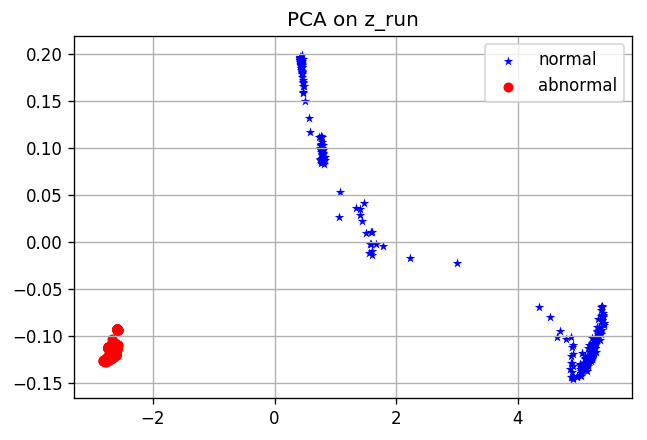

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.dpi'] = 120

# from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

z_run = z_mean.to(torch.device('cpu'))
z_run = z_run.detach().numpy()
PCA_model = TruncatedSVD(n_components=3).fit(z_run)
z_run_reduced = PCA_model.transform(z_run)
ground_truth = targets.to(torch.device('cpu'))
for k in range(batch_size):
    if ground_truth[k] ==1:
#z_mean, z_log_var, encoded, decoded = model(features, targets)
        plot1 = plt.scatter(z_run_reduced[k, 0], z_run_reduced[k, 1], c='b', marker='*', linewidths=0)
    else:
        plot2 = plt.scatter(z_run_reduced[k, 0], z_run_reduced[k, 1], c='r', marker='o', linewidths=0)        
plt.legend([plot1, plot2],('normal','abnormal'), loc='best')
plt.title('PCA on z_run')
plt.grid()
plt.show()

In [103]:
def data_to_real(inputdata):
    inputdata = inputdata * (inputdata.max()-inputdata.min()) + inputdata.min()
#    inputdata = 2.0 * inputdata - 1.0
    return inputdata

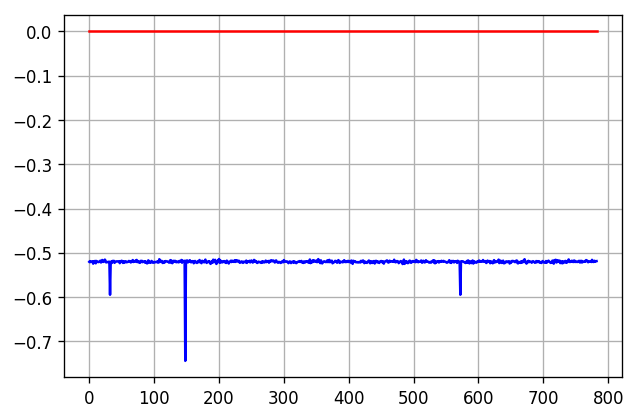

In [124]:
features1 = features.view(-1,28*28)
input_data = features1.to(torch.device('cpu'))
input_data = input_data.detach().numpy()
input_data = data_to_real(input_data)
input_data = input_data[:,:783]
de = model.decoder(z_mean, targets) # replace decoded by z_mean

decoded_data = de.to(torch.device('cpu'))
decoded_data = decoded_data.view(-1,28*28)
decoded_data = decoded_data.detach().numpy()
decoded_data = data_to_real(decoded_data)
decoded_data = decoded_data[:,:783]
idxx = np.random.randint(0,batch_size-1)
plt.plot(input_data[idxx],'b')
plt.plot(decoded_data[idxx],'r')
plt.grid()
plt.show()

### New random-conditional images

label
1.0


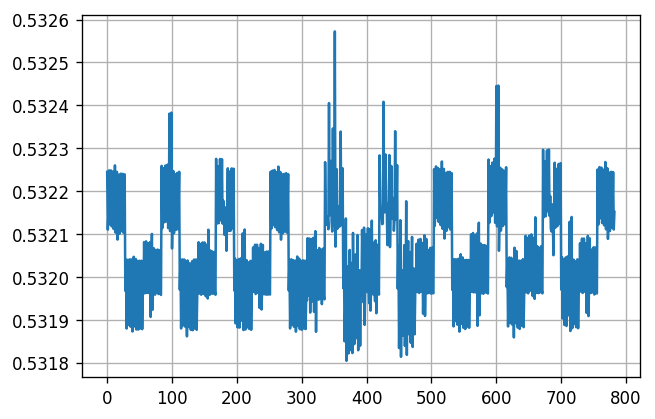

label
1.0


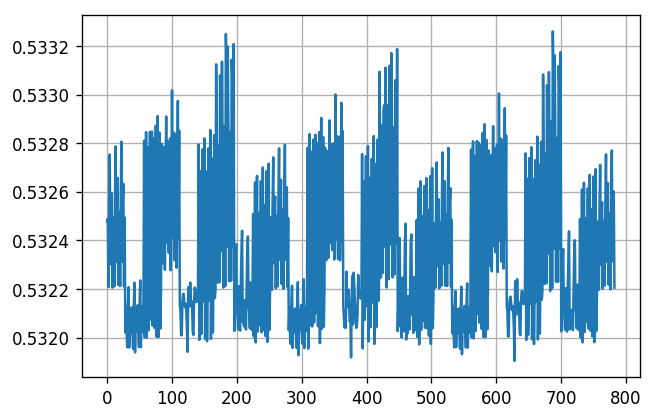

In [85]:
for i in range(2):
    labels = torch.tensor([i]*batch_size).to(device)
    n_images = labels.size()[0]
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_te = model.decoder(rand_features, labels)
    new_te = new_te.view(-1,28*28)
    curr_te = new_te.detach().to(torch.device('cpu'))
    curr_te = curr_te.detach().numpy()
    curr_te = data_to_real(curr_te)
    curr_te = curr_te[:,:783]
    idxx = np.random.randint(0,batch_size-1)
    plt.plot(curr_te[idxx])
    print('label')
    print(label[idxx])
    plt.grid()
    plt.show()

In [8]:
%watermark -iv

numpy       1.15.4
torch       1.0.0

